In [1]:
import numpy as np
import pandas as pd
import os
import math
import tensorflow as tf
import datetime

from keras import layers, models, activations
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.saving import register_keras_serializable
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

2024-07-25 16:38:28.792140: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 16:38:28.815965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 16:38:28.815989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 16:38:28.816003: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 16:38:28.820843: I tensorflow/core/platform/cpu_feature_g

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU


2024-07-25 16:38:30.077102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-25 16:38:30.077238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-25 16:38:30.080936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# dirs
DATA_DIR = "./load.csv"
TEST_PLOT_DIR = "./result/PhaCIA_TCNs/"
load_col = 'out.site_energy.total.energy_consumption.kwh'
# MW

In [4]:
if not os.path.exists(TEST_PLOT_DIR):
    os.makedirs(TEST_PLOT_DIR)
if not os.path.exists("./model"):
    os.makedirs("./model")
if not os.path.exists("./training_history"):
    os.makedirs("./training_history")

In [5]:
data = pd.read_csv(DATA_DIR)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data[load_col] = data[load_col] * 4 / 1e3


In [6]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[load_col].to_numpy().reshape(-1, 1))
data[load_col] = data_scaled

In [7]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [8]:
# Define a function to generate a list of timestamps every 2 hours within the dataset's range
def generate_timestamps(data) -> pd.DatetimeIndex:
    start = data['timestamp'].min() + DateOffset(days=3)
    end = data['timestamp'].max() - DateOffset(minutes=96*15)
    timestamps = pd.date_range(start=start, end=end, freq='15min')
    return timestamps

In [9]:
timestamps = generate_timestamps(data)
print(timestamps)

DatetimeIndex(['2018-01-04 00:15:00', '2018-01-04 00:30:00',
               '2018-01-04 00:45:00', '2018-01-04 01:00:00',
               '2018-01-04 01:15:00', '2018-01-04 01:30:00',
               '2018-01-04 01:45:00', '2018-01-04 02:00:00',
               '2018-01-04 02:15:00', '2018-01-04 02:30:00',
               ...
               '2018-12-30 21:45:00', '2018-12-30 22:00:00',
               '2018-12-30 22:15:00', '2018-12-30 22:30:00',
               '2018-12-30 22:45:00', '2018-12-30 23:00:00',
               '2018-12-30 23:15:00', '2018-12-30 23:30:00',
               '2018-12-30 23:45:00', '2018-12-31 00:00:00'],
              dtype='datetime64[ns]', length=34656, freq='15min')


In [10]:
def generate_sets_for_all_timestamps(timestamps, data):
    training_sets = []
    change_rate_sets = []
    target_sets = []
    training_sets_time = []
    target_sets_time = []

    for timestamp in timestamps:
        # Calculate the range for the current period's data
        start_time_current = timestamp - DateOffset(days=2, hours=23, minutes=45)
        end_time_current = timestamp

        # Calculate the target range (the next 10 steps after the current timestamp)
        target_start_time = timestamp + DateOffset(minutes=15)
        target_end_time = timestamp + DateOffset(hours=0, minutes=96*15) 

        # Filter the data for training and target sets
        current_data = data[(data['timestamp'] >= start_time_current) & (data['timestamp'] <= end_time_current)]
        target_data = data[(data['timestamp'] >= target_start_time) & (data['timestamp'] <= target_end_time)]

        # Combine current and last week data for the training set
        training_data = pd.concat([current_data]).reset_index(drop=True)
        
        # Save the training and target sets
        if not training_data.empty and not target_data.empty:
            training_sets.append(training_data[load_col])
            target_sets.append(target_data[load_col])
            training_sets_time.append(list(training_data['timestamp']))
            target_sets_time.append(list(target_data['timestamp']))

    training_sets = np.array(training_sets)
    target_sets = np.array(target_sets)
    training_sets_time = np.array(training_sets_time)
    target_sets_time = np.array(target_sets_time)

    return training_sets, target_sets, training_sets_time, target_sets_time


In [11]:
# Generate training and target sets for all the timestamps
training_sets, target_sets, training_sets_time, target_sets_time = generate_sets_for_all_timestamps(timestamps, data)

In [12]:
MONTH_TIME_STEP = math.floor(timestamps.shape[0] / 24)
X_test = []
y_test = []
X_test_time = []
y_test_time = []
minList = []
maxList = []
for i in range(0, 24):
    min = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    max = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test.append(training_sets[min:max])
    y_test.append(target_sets[min:max])
    X_test_time.append(training_sets_time[min:max])
    y_test_time.append(target_sets_time[min:max])
    training_sets = np.concatenate([training_sets[:min], training_sets[max:]])
    target_sets = np.concatenate([target_sets[:min], target_sets[max:]])
    training_sets_time = np.concatenate([training_sets_time[:min], training_sets_time[max:]])
    target_sets_time = np.concatenate([target_sets_time[:min], target_sets_time[max:]])


In [13]:
X_test = np.concatenate([i for i in X_test])
y_test = np.concatenate([i for i in y_test])
X_test_time = np.concatenate([i for i in X_test_time])
y_test_time = np.concatenate([i for i in y_test_time])

In [14]:
X_train = training_sets
X_test = X_test
y_train = target_sets
X_train_time = training_sets_time
y_train_time = target_sets_time

In [15]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)


(30048, 288)
(4608, 288)
(30048, 96)
(4608, 96)


In [16]:
svr = SVR()
model = MultiOutputRegressor(svr)
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=SVR())

In [17]:
y_pred = model.predict(X_test)

In [18]:
print(y_test.shape)
print(y_pred.shape)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("-" * 86)
print(f'mse: {mse:.4f}')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape: {mape: .4f}')
print(f'r2: {r2:.4f}')
print("-" * 86)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)


mse_inv = mean_squared_error(y_test_inv, y_pred_inv)
rmse_inv = math.sqrt(mse_inv)
mae_inv = mean_absolute_error(y_test_inv, y_pred_inv)
mape_inv = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
r2_inv = r2_score(y_test_inv, y_pred_inv)

print("-" * 86)
print(f'mse_inv: {mse_inv:.4f}')
print(f'rmse_inv: {rmse_inv:.4f}')
print(f'mae_inv: {mae_inv:.4f}')
print(f'mape_inv: {mape_inv: .4f}')
print(f'r2_inv: {r2_inv:.4f}')
print("-" * 86)

(4608, 96)
(4608, 96)
--------------------------------------------------------------------------------------
mse: 0.0022
rmse: 0.0474
mae: 0.0391
mape:  0.1633
r2: 0.9252
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
mse_inv: 457.2666
rmse_inv: 21.3838
mae_inv: 17.6205
mape_inv:  0.0463
r2_inv: 0.9252
--------------------------------------------------------------------------------------


In [19]:
def calculate_metrics_per_steps(true_values, predicted_values):
    n_steps = true_values.shape[1]

    mse = []
    rmse = []
    mae = []
    mape = []

    for i in range(n_steps):
        true_step = true_values[:, i]
        predicted_step = predicted_values[:, i]

        mse_step = mean_squared_error(true_step, predicted_step)
        rmse_step = np.sqrt(mse_step)
        mae_step = mean_absolute_error(true_step, predicted_step)
        mape_step = mean_absolute_percentage_error(true_step, predicted_step)

        mse.append(mse_step)
        rmse.append(rmse_step)
        mae.append(mae_step)
        mape.append(mape_step)

    return np.array(mse), np.array(rmse), np.array(mae), np.array(mape)

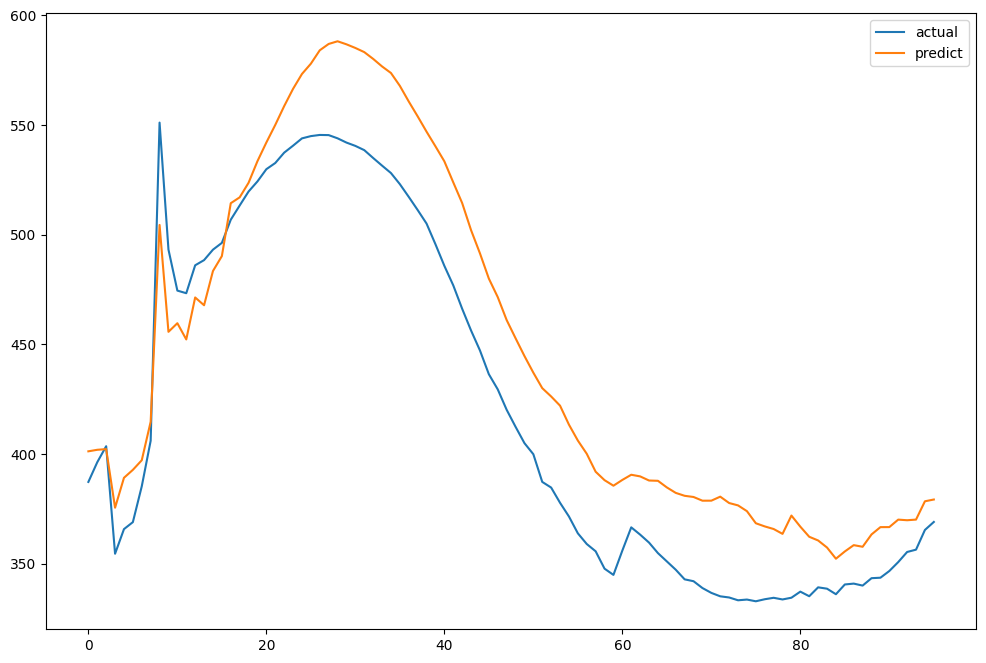

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv[960], label="actual")
plt.plot(y_pred_inv[960], label="predict")
plt.legend()
plt.show()

In [22]:
RESULT_DIR = "./result/"

In [23]:
result_df = pd.DataFrame(y_pred)
result_df.to_csv(RESULT_DIR+"SVR.csv")